In [1]:
import numpy as np

from matplotlib import pyplot as plt

from scipy.optimize import root_scalar

from shapely import LineString

from pycivil.sections.concreteSections import RectConcreteSct
import pycivil.sections.rebarSections as Rsct
import pycivil.sections.section as Sct
import pycivil.ACI318_19.sectional_strength.PMManalysis as PMManalysis
import pycivil.ACI318_19.designProps as props
import pycivil.ACI318_19.assumptions as assump

In [2]:
d20 = Rsct.d20

sct = RectConcreteSct(b=500, h=700)
sct.rebarCoords = Rsct.RectRebarsSct(sct.section, 5, 4, d20, 50)
# sct = CircConcreteSct(d=600)
# sct.rebarCoords = Rsct.CircRebarsSct(600, 7, d20, 70)

data = props.setDesignDataFromSection(sct)

In [3]:
def calc_Pc_list(data, angle, num=20, is_phi=True):
    c_max = calc_c_max(data, angle)
    c_list = np.linspace(1e-6, c_max, num=num, dtype=np.float32)
    P_list = np.array([PMManalysis.calc_P(data, _c, angle, is_phi) for _c in c_list], dtype=np.float32)
    return P_list, c_list


def calc_c(data, P, angle):
    def _optim_c(x):
        return PMManalysis.calc_P(data, x, angle) - P
    c_max = calc_c_max(data, angle)
    return root_scalar(_optim_c, bracket=[0.0001, c_max]).root


# * expired
def calc_c_max_opt(data, angle):
    def _optim_P0(x):
        return PMManalysis.calc_P(data, x, angle) - PMManalysis.calc_P0(data)
    rot_section = PMManalysis.rotate_section(data.section, angle)
    _, miny, _, maxy = rot_section.bounds
    return root_scalar(_optim_P0, x0=maxy-miny, x1=(maxy-miny)*3).root


def calc_c_max(data, angle):
    ety = data.fy / data.Es
    rot_section = PMManalysis.rotate_section(data.section, angle)
    _, _, _, maxy = rot_section.bounds
    rot_Coords = PMManalysis.rotate_rebar_coords(data.Coords, angle)
    miny_rebar = np.min([point.y for point in rot_Coords])
    dt = maxy - miny_rebar
    return dt / (1-(ety/assump.ecu))


def calc_PM_list(data, angle, num=20, is_phi=True):
    P_list, c_list = calc_Pc_list(data, angle, num, is_phi)
    M_list = np.array([PMManalysis.calc_M(data, _c, angle, is_phi) for _c in c_list], dtype=np.float32)
    M_list = M_list.reshape(-1, 3)
    return P_list, M_list


def calc_Mn(data, P, angle):
    c = calc_c(data, P, angle)
    return PMManalysis.calc_M(data, c, angle)


def calc_PM_ratio(data, P, Mx, My, angle:float|None=None):
    if angle == None: angle = calc_angle(data, P, Mx, My)
    M = pow(Mx**2 + My**2, 0.5)
    e = M/P
    P_list, M_list = calc_PM_list(data, angle)
    M_custom = np.max(M_list[:,0]) * 1.1
    P_custom = M_custom/e

    PM_line = LineString(list(zip(M_list[:,0], P_list)))
    PMx_line = LineString([(0, 0), (M_custom, P_custom)])
    
    inter_point = PM_line.intersection(PMx_line)
    _M = inter_point.x
    _P = inter_point.y
    return P/_P if P!=0 else M/_M


def calc_percent(data, P, Mx, My, ratio=1, num=8):
    angle = calc_angle(data, P, Mx, My)
    def _optim_percent(x):
        data_percent = PMManalysis.set_As_percent(data, x)
        c = calc_c(data_percent, P, angle)
        return PMManalysis.calc_M(data_percent, c, angle)[0] - pow(Mx**2+My**2, 0.5)
    
    data_one_percent = PMManalysis.set_As_percent(data, 1)
    data_eight_percent = PMManalysis.set_As_percent(data, 8)
    if calc_PM_ratio(data_one_percent, P, Mx, My, angle) <= 1: 
        output_percent = 1
    elif calc_PM_ratio(data_eight_percent, P, Mx, My, angle) > 1:
        raise ValueError("section is weak")
    else:
        output_percent = root_scalar(_optim_percent, bracket=[1, 8])
        # percent_list = np.linspace(1, 8, num=num, dtype=np.float32)
        # data_list = np.array([PMManalysis.set_As_percent(data, percent) for percent in percent_list])
        # PM_ratio_list = np.array([calc_PM_ratio(_data, P, Mx, My, angle) for _data in data_list], dtype=np.float32)
        # func = interp1d(PM_ratio_list, percent_list)
        # output_percent = func(ratio)
    return output_percent


def calc_angle(data, P, Mx, My):
    alpha = PMManalysis.calc_alpha(Mx, My)
    def _optim_angle(x):
        c = calc_c(data, P, x)
        _, _Mx, _My = PMManalysis.calc_M(data, c, x)
        return PMManalysis.calc_alpha(_Mx, _My) - alpha
    
    lbound = 0 if 0<=alpha<=90 else 90 if 90<alpha<=180 else\
         180 if 180<alpha<=270 else 270
         
    ubound = 90 if 0<=alpha<=90 else 180 if 90<alpha<=180 else\
         270 if 180<alpha<=270 else 360
    
    return root_scalar(_optim_angle, bracket=[lbound, ubound]).root

In [4]:
Pu = 3e6
Mux = 2e8
Muy = 1e8

Mu = pow(Mux**2 + Muy**2, 0.5)
alpha = PMManalysis.calc_alpha(Mux, Muy)
angle = calc_angle(data, Pu, Mux, Muy)
e = Mu/Pu

calc_PM_ratio(data, Pu, Mux, Muy, angle)

0.6506413122443448

In [5]:
P_phi_list, M_phi_list = calc_PM_list(data, angle, 100, is_phi=True)
P_list, M_list = calc_PM_list(data, angle, 100, is_phi=False)

P0 = PMManalysis.calc_P0(data)
Pn_max = PMManalysis.calc_Pn_max(data)
M_max = np.max(M_phi_list[:,0])

PM_line = LineString(list(zip(M_phi_list[:,0], P_phi_list)))
PMx_line = LineString([(0, Pn_max), (M_max, Pn_max)])
    
Pn_max_point = PM_line.intersection(PMx_line)

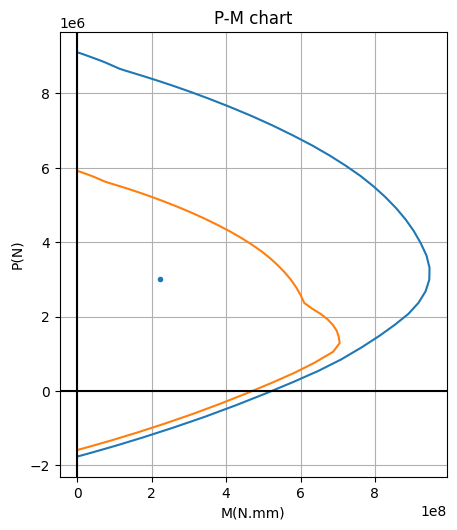

In [7]:
fig, axs = plt.subplots(figsize=(5,7))
axs.plot(M_list[:,0], P_list)
axs.plot(M_phi_list[:,0], P_phi_list)
# axs.hlines(y=Pn_max, xmin=0, xmax=Pn_max_point.x, linewidth=1, color='r')
axs.set_aspect(100)
axs.scatter(Mu, Pu, marker=".") # type: ignore
axs.set_title(f"P-M chart")
axs.set_ylabel("P(N)")
axs.set_xlabel("M(N.mm)")
axs.axhline(y=0, color='k', linestyle='-')
axs.axvline(x=0, color='k', linestyle='-')
axs.grid(True)
plt.show()

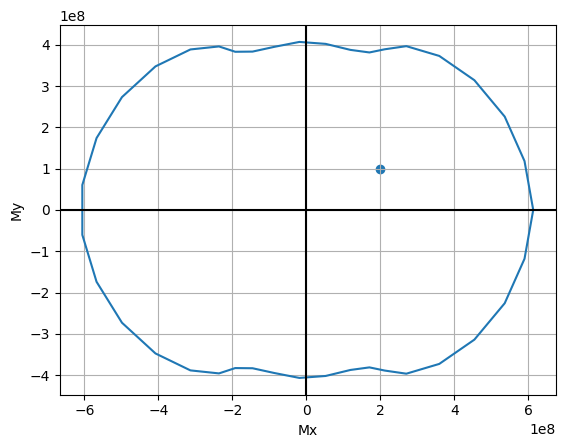

In [77]:
angle_list = np.linspace(0, 360, 40)
Mxy_list = np.array([calc_Mn(data, Pu, _angle) for _angle in angle_list])

fig, axs = plt.subplots()
axs.plot(Mxy_list[:, 1], Mxy_list[:, 2])
axs.scatter(Mux, Muy)
axs.axhline(y=0, color='k', linestyle='-')
axs.axvline(x=0, color='k', linestyle='-')
axs.set_xlabel("Mx")
axs.set_ylabel("My")
axs.grid(True)
plt.show()

In [61]:
calc_percent(data, Pu, Mux, Muy)

1

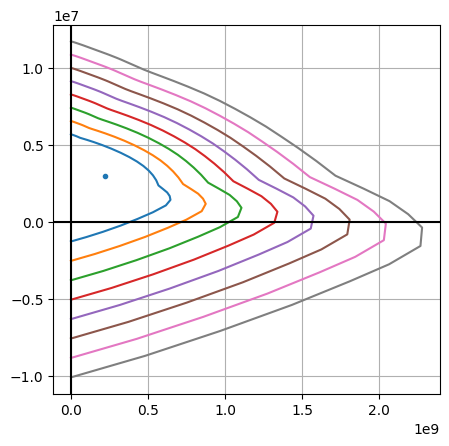

In [78]:
percent_list = np.linspace(1, 8, num=8)
data_list = np.array([PMManalysis.set_As_percent(data, percent) for percent in percent_list])

fig, axs = plt.subplots()
for _data in data_list:
    P_list, M_list = calc_PM_list(_data, angle, 60)
    axs.plot(M_list[:,0], P_list)
axs.set_aspect(100)
axs.scatter(Mu, Pu, marker=".")
axs.axhline(y=0, color='k', linestyle='-')
axs.axvline(x=0, color='k', linestyle='-')
axs.grid(True)
plt.show()